<a href="https://colab.research.google.com/github/tousifo/ml_notebooks/blob/main/pimcl_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preprocess

In [ ]:
import os
import zipfile
import glob
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from sklearn.model_selection import StratifiedShuffleSplit

# Paths & Extraction
ZIP_PATH    = "/content/drive/MyDrive/oaisis.zip"
EXTRACT_DIR = "/content/oasis_data"

if not os.path.exists(EXTRACT_DIR) or not os.listdir(EXTRACT_DIR):
    print(f"Extracting {ZIP_PATH} -> {EXTRACT_DIR}...")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
        zf.extractall(EXTRACT_DIR)

# Detect true data root
LABEL_MAP = {
    "Non Demented":       0,
    "Very mild Dementia": 1,
    "Mild Dementia":      2,
    "Moderate Dementia":  3
}

candidates = [EXTRACT_DIR] + [os.path.join(EXTRACT_DIR, d) for d in os.listdir(EXTRACT_DIR)]
DATA_ROOT = None
for cand in candidates:
    if all(os.path.isdir(os.path.join(cand, lbl)) for lbl in LABEL_MAP):
        DATA_ROOT = cand
        break
if DATA_ROOT is None:
    raise RuntimeError(f"Could not find class folders under {EXTRACT_DIR}")
print("Using data root:", DATA_ROOT)

# Build samples & split
all_samples = []
for label_name, lbl in LABEL_MAP.items():
    pattern = os.path.join(DATA_ROOT, label_name, "*.jpg")
    files = glob.glob(pattern)
    if not files:
        raise RuntimeError(f"No images for '{label_name}' in {pattern}")
    all_samples += [(fp, lbl) for fp in files]

paths, labels = zip(*all_samples)
labels = np.array(labels)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(sss.split(paths, labels))
train_list = [all_samples[i] for i in train_idx]
val_list   = [all_samples[i] for i in val_idx]

# Compute class weights
train_labels = labels[train_idx]
class_counts = np.bincount(train_labels, minlength=len(LABEL_MAP))
class_weights = torch.tensor(1.0 / class_counts, dtype=torch.float32)

# Sampler
sample_weights = [class_weights[lbl].item() for _, lbl in train_list]
train_sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

# Patch Extraction
PATCH_SIZE = (32, 32)
LARGE_SIZE = (64, 64)
NUM_PATCHES = 25

def extract_multi_scale_patches(img_t, num_patches=NUM_PATCHES,
                                patch_size=PATCH_SIZE, large_size=LARGE_SIZE):
    C, H, W = img_t.shape
    patches = []
    ph, pw = patch_size
    ph2, pw2 = large_size

    # Center
    top_c = H//2 - ph//2
    left_c= W//2 - pw//2
    patches.append(img_t[:, top_c:top_c+ph, left_c:left_c+pw])

    # Random small
    small_n = int((num_patches-1)*0.5)
    for _ in range(small_n):
        t = np.random.randint(0, H-ph+1)
        l = np.random.randint(0, W-pw+1)
        patches.append(img_t[:, t:t+ph, l:l+pw])

    # Random large
    large_n = (num_patches-1-small_n)
    for _ in range(large_n):
        t = np.random.randint(0, H-ph2+1)
        l = np.random.randint(0, W-pw2+1)
        lp = img_t[:, t:t+ph2, l:l+pw2].unsqueeze(0)
        lp_res = F.interpolate(lp, size=patch_size, mode='bilinear', align_corners=False)
        patches.append(lp_res.squeeze(0))

    return torch.stack(patches[:num_patches], dim=0)

# Dataset & DataLoaders
class OASISPatchDataset(Dataset):
    def __init__(self, samples, transform):
        self.samples = samples
        self.transform = transform
    def __len__(self): return len(self.samples)
    def __getitem__(self, i):
        fp, lbl = self.samples[i]
        img = Image.open(fp).convert('L')
        img_t = self.transform(img)
        patches = extract_multi_scale_patches(img_t)
        return patches, lbl

train_tf = transforms.Compose([
    transforms.Resize(280),
    transforms.RandomCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
])
val_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
])

train_ds = OASISPatchDataset(train_list, train_tf)
val_ds   = OASISPatchDataset(val_list,   val_tf)

BATCH_SIZE = 16
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                          sampler=train_sampler, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=2)

Extracting /content/drive/MyDrive/oaisis.zip -> /content/oasis_data...
Using data root: /content/oasis_data/Data


#Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

EMBED_DIM   = 128
NUM_CLASSES = 4  # Number of classes from LABEL_MAP
TEMPERATURE = 0.1
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PatchResNet(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        resnet = torchvision.models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc   = nn.Linear(resnet.fc.in_features, embed_dim)
    def forward(self, x):
        B,N = x.shape[:2]
        x = x.view(B*N, 3, *x.shape[-2:])
        x = self.backbone(x)
        x = self.pool(x).view(B*N, -1)
        x = F.normalize(self.fc(x), dim=1)
        return x.view(B, N, -1)

class TopKAttentionMIL(nn.Module):
    def __init__(self, embed_dim, num_classes, k=5):
        super().__init__()
        self.scorer = nn.Linear(embed_dim,1)
        self.cls    = nn.Linear(embed_dim,num_classes)
        self.k      = k
    def forward(self, emb):
        scores = self.scorer(emb).squeeze(-1)
        topv, topi = torch.topk(scores, self.k, dim=1)
        idx = topi.unsqueeze(-1).expand(-1,-1,emb.size(-1))
        sel = emb.gather(1, idx)
        M = sel.mean(dim=1)
        return self.cls(M), scores

class PrototypeContrastiveLoss(nn.Module):
    def __init__(self, n_cls, dim, temp):
        super().__init__()
        self.protos = nn.Parameter(torch.randn(n_cls, dim))
        self.temp   = temp
    def forward(self, emb, labels):
        B,N,D = emb.shape
        flat = emb.view(B*N, D)
        labs = labels.unsqueeze(1).repeat(1,N).view(-1)
        sims = F.cosine_similarity(flat.unsqueeze(1), self.protos.unsqueeze(0), dim=-1)/self.temp
        return F.cross_entropy(sims, labs)

class PMICL2D_ResNet_TopK(nn.Module):
    def __init__(self, embed_dim, num_classes, temperature, topk=5):
        super().__init__()
        self.encoder    = PatchResNet(embed_dim)
        self.aggregator = TopKAttentionMIL(embed_dim,num_classes, k=topk)
        self.prot_loss  = PrototypeContrastiveLoss(num_classes, embed_dim, temperature)
    def forward(self, patches, labels=None):
        patches = patches.repeat(1,1,3,1,1)
        emb, _ = self.encoder(patches), None
        logits, scores = self.aggregator(emb)
        p_loss = self.prot_loss(emb, labels) if labels is not None else 0
        return logits, p_loss, scores
    def bag_embedding(self, patches):
        with torch.no_grad():
            patches = patches.repeat(1,1,3,1,1)
            emb = self.encoder(patches)
            scores = self.aggregator.scorer(emb).squeeze(-1)
            topv, topi = torch.topk(scores, self.aggregator.k, dim=1)
            idx = topi.unsqueeze(-1).expand(-1,-1,emb.size(-1))
            sel = emb.gather(1, idx)
            return sel.mean(dim=1).cpu().numpy()

#Train

In [ ]:
from sklearn.metrics import f1_score
from tqdm import tqdm

PROTO_WEIGHT = 0.1

def train_mil_only(model, loader, epochs=10, lr=1e-4):
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    for ep in range(1, epochs+1):
        model.train()
        all_p, all_t = [], []
        for patches, labels in tqdm(loader, desc=f"MIL-only Ep{ep}"):
            patches, labels = patches.to(DEVICE), labels.to(DEVICE)
            opt.zero_grad()
            logits, _, _ = model(patches, labels)
            loss = F.cross_entropy(logits, labels)
            loss.backward(); opt.step()
            preds = logits.argmax(1)
            all_p += preds.cpu().tolist(); all_t += labels.cpu().tolist()
        print(f"Ep{ep} MIL-only F1={f1_score(all_t, all_p, average='weighted'):.4f}")

def pretrain_encoder(model, loader, epochs=5, lr=1e-4):
    enc = model.encoder
    opt = torch.optim.AdamW(enc.parameters(), lr=lr)
    for ep in range(1, epochs+1):
        enc.train()
        total=0
        for patches, labels in tqdm(loader, desc=f"Proto-pretrain Ep{ep}"):
            patches, labels = patches.to(DEVICE), labels.to(DEVICE)
            opt.zero_grad()
            patches3 = patches.repeat(1,1,3,1,1)
            emb = enc(patches3)
            loss = model.prot_loss(emb, labels)
            loss.backward(); opt.step()
            total += loss.item()
        print(f"Ep{ep} Proto Loss={total/len(loader):.4f}")

def train_mil_head(model, loader, epochs=5, lr=1e-4):
    for p in model.encoder.parameters(): p.requires_grad=False
    opt = torch.optim.AdamW(model.aggregator.parameters(), lr=lr)
    for ep in range(1, epochs+1):
        model.train()
        all_p, all_t=[],[]; total=0
        for patches, labels in tqdm(loader, desc=f"MIL-head Ep{ep}"):
            patches, labels=patches.to(DEVICE),labels.to(DEVICE)
            opt.zero_grad()
            logits, _, _ = model(patches, labels)
            loss = F.cross_entropy(logits, labels)
            loss.backward(); opt.step(); total+=loss.item()
            preds=logits.argmax(1)
            all_p+=preds.cpu().tolist(); all_t+=labels.cpu().tolist()
        print(f"Ep{ep} MIL-head F1={f1_score(all_t, all_p, average='weighted'):.4f}")

def fine_tune_end2end(model, loader, epochs=10, lr=1e-5, proto_weight=PROTO_WEIGHT):
    for p in model.encoder.parameters(): p.requires_grad=True
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    for ep in range(1, epochs+1):
        model.train()
        all_p, all_t=[],[]; total=0
        for patches, labels in tqdm(loader, desc=f"FT Ep{ep}"):
            patches, labels=patches.to(DEVICE),labels.to(DEVICE)
            opt.zero_grad()
            logits, p_loss, _ = model(patches, labels)
            c_loss=F.cross_entropy(logits, labels)
            loss = (1-proto_weight)*c_loss + proto_weight*p_loss
            loss.backward(); opt.step(); total+=loss.item()
            preds=logits.argmax(1)
            all_p+=preds.cpu().tolist(); all_t+=labels.cpu().tolist()
        print(f"Ep{ep} FT F1={f1_score(all_t, all_p, average='weighted'):.4f}")

#Evaluation

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 152MB/s]



=== Phase 0: MIL-only Baseline ===


MIL-only Ep1: 100%|██████████| 4322/4322 [05:50<00:00, 12.34it/s]


Ep1 MIL-only F1=0.4698


MIL-only Ep2: 100%|██████████| 4322/4322 [05:52<00:00, 12.27it/s]


Ep2 MIL-only F1=0.5658


MIL-only Ep3: 100%|██████████| 4322/4322 [05:45<00:00, 12.50it/s]


Ep3 MIL-only F1=0.6177


MIL-only Ep4: 100%|██████████| 4322/4322 [05:42<00:00, 12.62it/s]


Ep4 MIL-only F1=0.6528


MIL-only Ep5: 100%|██████████| 4322/4322 [05:41<00:00, 12.67it/s]


Ep5 MIL-only F1=0.6730


MIL-only Ep6: 100%|██████████| 4322/4322 [05:40<00:00, 12.69it/s]


Ep6 MIL-only F1=0.6891


MIL-only Ep7: 100%|██████████| 4322/4322 [05:41<00:00, 12.67it/s]


Ep7 MIL-only F1=0.7014


MIL-only Ep8: 100%|██████████| 4322/4322 [05:39<00:00, 12.74it/s]


Ep8 MIL-only F1=0.7132


MIL-only Ep9: 100%|██████████| 4322/4322 [05:39<00:00, 12.74it/s]


Ep9 MIL-only F1=0.7239


MIL-only Ep10: 100%|██████████| 4322/4322 [05:40<00:00, 12.68it/s]


Ep10 MIL-only F1=0.7320


Evaluating: 100%|██████████| 1081/1081 [00:59<00:00, 18.29it/s]


Validation Accuracy: 0.7075
Validation F1 Score: 0.7454
Confusion Matrix:
[[9573 2917  801  154]
 [ 207 1831  591  116]
 [  17  206  730   47]
 [   0    0    1   97]]


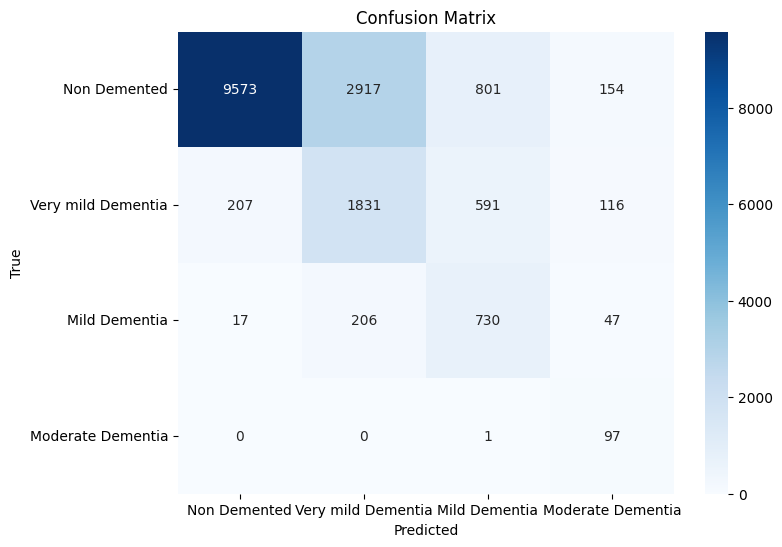


=== Phase 1: Prototype Pre-training ===


Proto-pretrain Ep1: 100%|██████████| 4322/4322 [05:41<00:00, 12.67it/s]


Ep1 Proto Loss=1.1100


Proto-pretrain Ep2: 100%|██████████| 4322/4322 [05:38<00:00, 12.78it/s]


Ep2 Proto Loss=1.0335


Proto-pretrain Ep3: 100%|██████████| 4322/4322 [05:37<00:00, 12.80it/s]


Ep3 Proto Loss=0.9967


Proto-pretrain Ep4: 100%|██████████| 4322/4322 [05:38<00:00, 12.77it/s]


Ep4 Proto Loss=0.9705


Proto-pretrain Ep5: 100%|██████████| 4322/4322 [05:38<00:00, 12.78it/s]


Ep5 Proto Loss=0.9505


Evaluating: 100%|██████████| 1081/1081 [00:57<00:00, 18.79it/s]


Validation Accuracy: 0.5842
Validation F1 Score: 0.6559
Confusion Matrix:
[[8567  627 4251    0]
 [ 248  545 1951    1]
 [  10    8  982    0]
 [  11   56   26    5]]


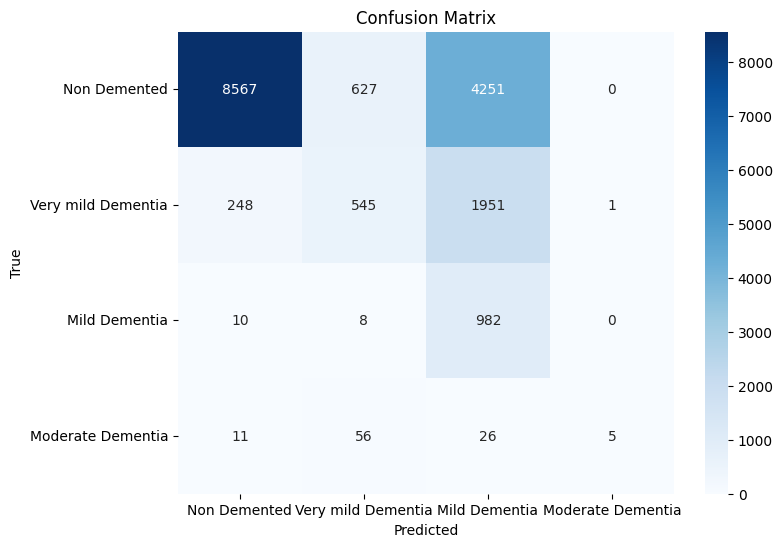


=== Phase 2: MIL-head Training ===


MIL-head Ep1: 100%|██████████| 4322/4322 [04:44<00:00, 15.20it/s]


Ep1 MIL-head F1=0.6950


MIL-head Ep2: 100%|██████████| 4322/4322 [04:40<00:00, 15.39it/s]


Ep2 MIL-head F1=0.7396


MIL-head Ep3: 100%|██████████| 4322/4322 [04:46<00:00, 15.10it/s]


Ep3 MIL-head F1=0.7510


MIL-head Ep4: 100%|██████████| 4322/4322 [04:44<00:00, 15.19it/s]


Ep4 MIL-head F1=0.7560


MIL-head Ep5: 100%|██████████| 4322/4322 [04:43<00:00, 15.24it/s]


Ep5 MIL-head F1=0.7601


Evaluating: 100%|██████████| 1081/1081 [00:57<00:00, 18.78it/s]


Validation Accuracy: 0.7608
Validation F1 Score: 0.7862
Confusion Matrix:
[[10513  2085   749    98]
 [  376  1724   565    80]
 [   22   140   820    18]
 [    0     2     1    95]]


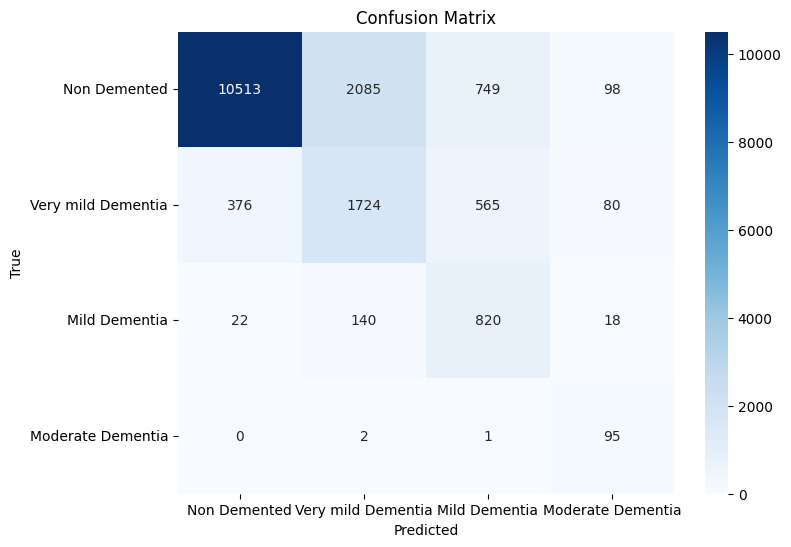


=== Phase 3: End-to-End Fine-tuning ===


FT Ep1: 100%|██████████| 4322/4322 [05:41<00:00, 12.64it/s]


Ep1 FT F1=0.7904


FT Ep2: 100%|██████████| 4322/4322 [05:42<00:00, 12.60it/s]


Ep2 FT F1=0.8037


FT Ep3: 100%|██████████| 4322/4322 [05:46<00:00, 12.48it/s]


Ep3 FT F1=0.8077


FT Ep4:  17%|█▋        | 717/4322 [00:57<05:12, 11.53it/s]

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Define LABEL_MAP for plotting (same as in preprocess_data)
LABEL_MAP = {
    "Non Demented":       0,
    "Very mild Dementia": 1,
    "Mild Dementia":      2,
    "Moderate Dementia":  3
}

def evaluate_model(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for patches, labels in tqdm(val_loader, desc="Evaluating"):
            patches = patches.to(DEVICE)
            logits, _, _ = model(patches)
            preds = logits.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Validation Accuracy: {accuracy:.4f}")
    print(f"Validation F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=LABEL_MAP.keys(),
                yticklabels=LABEL_MAP.keys())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return f1

if __name__ == "__main__":
    model = PMICL2D_ResNet_TopK(EMBED_DIM, NUM_CLASSES, TEMPERATURE, topk=5).to(DEVICE)

    val_f1_scores = []

    print("\n=== Phase 0: MIL-only Baseline ===")
    train_mil_only(model, train_loader, epochs=10, lr=1e-4)
    val_f1 = evaluate_model(model, val_loader)
    val_f1_scores.append(val_f1)

    print("\n=== Phase 1: Prototype Pre-training ===")
    pretrain_encoder(model, train_loader, epochs=5, lr=1e-4)
    val_f1 = evaluate_model(model, val_loader)
    val_f1_scores.append(val_f1)

    print("\n=== Phase 2: MIL-head Training ===")
    train_mil_head(model, train_loader, epochs=5, lr=1e-4)
    val_f1 = evaluate_model(model, val_loader)
    val_f1_scores.append(val_f1)

    print("\n=== Phase 3: End-to-End Fine-tuning ===")
    fine_tune_end2end(model, train_loader, epochs=10, lr=1e-5, proto_weight=0.1)
    val_f1 = evaluate_model(model, val_loader)
    val_f1_scores.append(val_f1)

    # Plot validation curve
    phases = ['Phase 0', 'Phase 1', 'Phase 2', 'Phase 3']
    plt.figure(figsize=(8,6))
    plt.plot(phases, val_f1_scores, marker='o')
    plt.xlabel('Training Phase')
    plt.ylabel('Validation F1 Score')
    plt.title('Validation Curve')
    plt.show()